
# Fit report for Ar_200microlH2_200microlCH4.txt
## File statistics:
data points : 7499
variables   : 17
χ²          : 3.6704e+04
red. χ²     : 4.9057e+00
R²          : 0.9988

## Fit results:
Background c: -4.8506±0.0437

|   Center /min |       Amplitude |        Area |    Normalized |
|---------------|-----------------|-------------|---------------|
| 1.1492±0.0001 | -58.6486±0.0484 | 39.85±0.03% | 3.3838±0.0102 |
| 1.5232±0.0003 | -18.5658±0.0408 | 12.61±0.03% | 1.0712±0.0038 |
| 1.8732±0.0001 | -52.6337±0.0430 | 35.76±0.03% | 3.0367±0.0091 |
| 2.6513±0.0005 | -17.3324±0.0519 | 11.78±0.03% |      1.0000±0 |


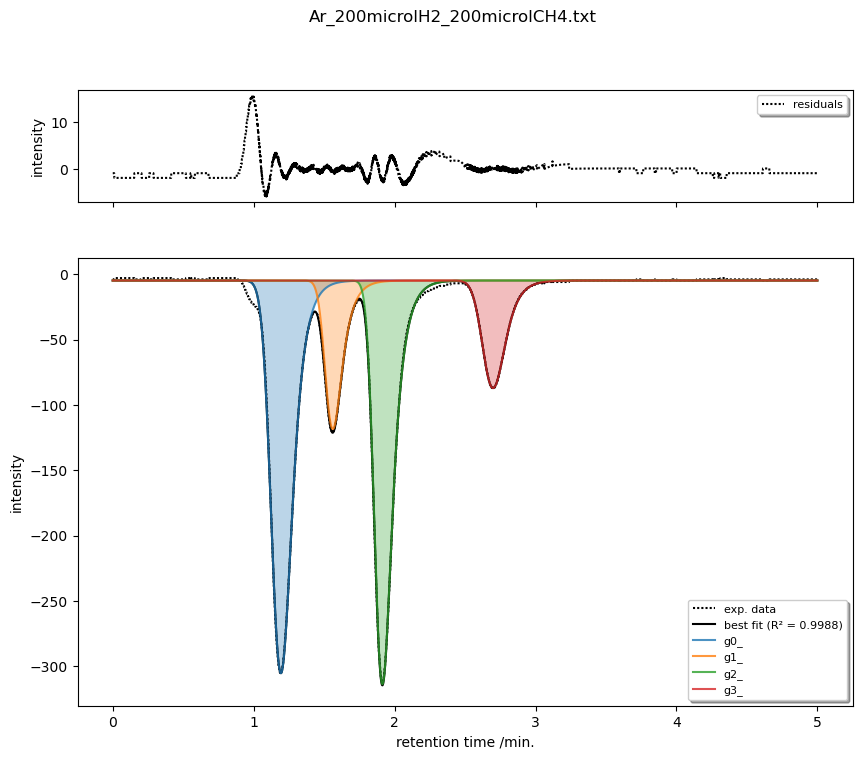

In [7]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# gc-fit.py
#


##########################################################################################
import sys                                                      #sys

import matplotlib.pyplot as plt                                 #plots
import numpy as np                                              #summation and other math

from lmfit.models import ExponentialGaussianModel, ConstantModel            #fit
from lmfit import Parameters                                                #fit

from scipy.signal import find_peaks                                         #peak finding
from tabulate import tabulate                                               #tables
##########################################################################################

#for windows console
#sys.stdout.reconfigure(encoding = 'utf-8') #unicode

def imp_data(file):
    exp_data = []
    try:
        with open(file, 'r') as input_file:
            for line in input_file:
                if line[0].isdigit():
                    rtime, intens = line.replace(',','.').replace('\n','').split('\t')
                    exp_data.append([float(rtime), float(intens)])
    except IOError:
        #file not found -> exit here
        print(f"'{file}'" + " not found. Exit.")
        sys.exit(1)
    except ValueError:
        print('Warning! Wrong data format. Exit.')
        sys.exit(1)
    return np.array(exp_data),file

def get_peaks(exp_data, prom = 4):
    intens = exp_data[:,1]
    peak_pos, _ = find_peaks(-intens, prominence = prom)
    return peak_pos

def do_the_fit(exp_data, peak_pos):
    rtime = exp_data[:,0]
    intens = (exp_data[:,1])
    exp_gaussians = []
    params = Parameters()  
    
    for index, peak in enumerate(peak_pos): 
        # if the fit does not work, change sigma_max, center_rtime[peak] ± 0.x or gamma_max 
        exp_gauss =  ExponentialGaussianModel(prefix = 'g' + str(index) + "_") 
        params.update(exp_gauss.guess(intens, x = rtime))
        params.update(exp_gauss.make_params(center = dict(value = rtime[peak], 
                                                            min = rtime[peak] - 0.2, 
                                                            max = rtime[peak] + 0.2),
                                             amplitude = dict(value = intens[peak]*0.1, 
                                                                min = 0.01, 
                                                                max = intens[peak]),
                                             sigma = dict(value = 0.01, 
                                                            min = 0.001, 
                                                            max = 0.1),
                                             gamma = dict(value = 15, 
                                                            min = 0, 
                                                            max = 30)
        ))
        exp_gaussians.append(exp_gauss)
    
    bg = ConstantModel()
    # if the fit does not work, changing max might help 
    bg_params = bg.make_params(c = dict(value = 0, min = 0, max = -10))
    curve = np.sum(exp_gaussians) + bg
    fit_results = curve.fit(intens, params + bg_params, x = rtime)
    #print(fit_results.fit_report())
    #fit_results.plot_fit()
    return fit_results

def plot_results(exp_data, fit_results,filename):
    rtime = exp_data[:,0]
    intens = (exp_data[:,1])
    fig, (ax0, ax1) = plt.subplots(2, 1, figsize = (10,8), 
                      gridspec_kw = {'height_ratios': [1, 4]}, sharex = True)
    comps = fit_results.eval_components(x = rtime)
    fitted_params = fit_results.params.valuesdict()
    
    ax1.plot(rtime, intens, 
            linestyle = (0, (1, 1)), 
            color = 'black', 
            label ='exp. data')
    ax1.plot(rtime, fit_results.best_fit, 
             color='black', 
             label = 'best fit (R² = '+ '{:.4}'.format(fit_results.rsquared) + ')')
    #ax1.fill_between(rtime, fit_results.best_fit, fitted_params['c'], alpha = 0.3)
    
    ax0.plot(rtime, fit_results.residual, 
             linestyle = (0, (1, 1)), 
             color = 'black', 
             label = 'residuals')
    
    for component in comps:
        if not 'constant' in component:
            ax1.plot(rtime, comps[component] + fitted_params['c'], 
                     label = component, 
                     alpha = 0.8)
            ax1.fill_between(rtime, comps[component] + fitted_params['c'], 
                             fitted_params['c'], 
                             alpha= 0.3)
    
    fig.suptitle(filename)
    ax0.legend(fancybox = True, shadow = True, loc='upper right', prop={'size': 8})
    ax1.legend(fancybox = True, shadow = True, loc='lower right', prop={'size': 8})
    ax1.set_xlabel('retention time /min.')
    ax0.set_ylabel('intensity')
    ax1.set_ylabel('intensity')
    plt.show()

def print_results(fit_results, filename):
    results_table1 = []
    print('')
    print('# Fit report for ' + filename)
    print('## File statistics:')
    print('data points : ' + str(fit_results.ndata))
    print('variables   : ' + str(fit_results.nvarys))
    print('χ²          : ' + '{:.4e}'.format(fit_results.chisqr))
    print('red. χ²     : ' + '{:.4e}'.format(fit_results.redchi))
    print('R²          : ' + '{:.4}'.format(fit_results.rsquared))
    print('')
    print('## Fit results:')
    print('Background c:', u'{:.4fP}'.format(fit_results.uvars['c']))
    
    last_amp = [v for k, v in fit_results.uvars.items() if 'amplitude' in k][-1]
    
    amp_sum = sum([v for k, v in fit_results.uvars.items() if 'amplitude' in k])
    
    amp_prop = [u'{:.2fP}%'.format(abs(v/amp_sum*100)) 
                for k, v in fit_results.uvars.items() 
                if 'amplitude' in k]
                
    amp_norm_last = [u'{:.4fP}'.format(abs(v/last_amp)) 
                     for k, v in fit_results.uvars.items() 
                     if 'amplitude' in k]
                     
    amplitude_values = [u'{:.4fP}'.format(v) 
                        for k, v in fit_results.uvars.items() 
                        if 'amplitude' in k]
                        
    center_values = [u'{:.4fP}'.format(v) 
                     for k, v in fit_results.uvars.items() 
                     if 'center' in k]
                     
    center_amp = [[center, amplitude, amp_prop, amp_norm_last] 
                   for center, amplitude, amp_prop, amp_norm_last 
                   in zip(center_values, amplitude_values, amp_prop, amp_norm_last)]
    
    print('')
    print(tabulate(center_amp,
            #'disable_numparse', otherwise tabulate ignores the formatting
            disable_numparse = True,
            headers=['Center /min', 'Amplitude', 'Area', 'Normalized'], 
            stralign="decimal",
            tablefmt='github',
            showindex=False))


exp_data, filename = imp_data("Ar_200microlH2_200microlCH4.txt")
peak_pos = get_peaks(exp_data)
fit_results = do_the_fit(exp_data, peak_pos)
print_results(fit_results, filename)
plot_results(exp_data,fit_results,filename)

import sys
!{sys.executable} -m pip install lmfit

In [5]:
import sys
!{sys.executable} -m pip install tabulate